# Seattle Fremont Bridge Hourly Bike Counter using Jupyter Notebook
*Follwoing Jake Vanderplas*

By Takaoki Koyanagi

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import seaborn as sns
import pandas as pd

## Created a python package to get data, with unit testing to ensure code loads properly 

In [2]:
from Timeseries_workflow.data import get_fremont_data 

In [3]:
data = get_fremont_data()

# Exploratory Data Analysis

## EDA: Look at weekly bike counter patterns

<Figure size 7200x3600 with 0 Axes>

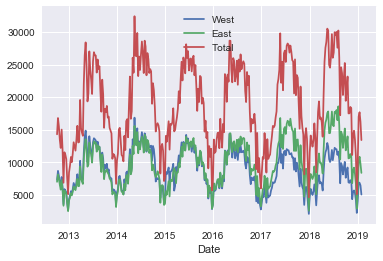

In [4]:
plt.figure(figsize = (100,50))
data.resample('W').sum().plot()


### Seems difficult to determine much from this plot

## EDA: Look at rolling average of days for bike counter patterns

(0, 1098983.95)

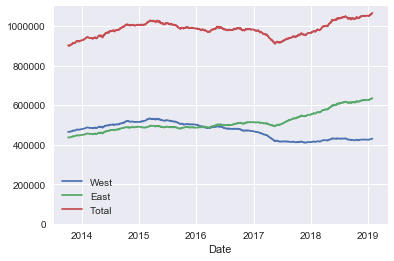

In [5]:
ax = data.resample('D').sum().rolling(365).sum().plot()
ax.set_ylim(0, None)

### Looks like there are more counts in the East side vs. the West side starting from 2017 to 2019

## Let's group the index (time) and plot the mean to glean insight into when each side of the bridge is busy

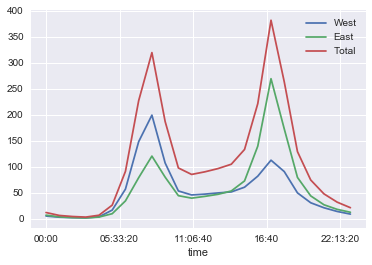

In [6]:
data.groupby(data.index.time).mean().plot()

### The plot suggests a commuting pattern where the West side is busy in the morning, whereas, the East side becomes busy around 4:40 pm

## Diving deeper into the data, let's create a pivot table of the total number of counts with the index being the time and columns being each day

In [7]:
pivoted = data.pivot_table('Total', index=data.index.time, columns = data.index.date)
pivoted.iloc[:5, :5]

,2012-10-03,2012-10-04,2012-10-05,2012-10-06,2012-10-07
00:00:00,13.0,18.0,11.0,15.0,11.0
01:00:00,10.0,3.0,8.0,15.0,17.0
02:00:00,2.0,9.0,7.0,9.0,3.0
03:00:00,5.0,3.0,4.0,3.0,6.0
04:00:00,7.0,8.0,9.0,5.0,3.0


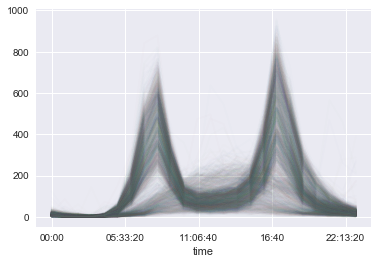

In [8]:
pivoted.plot(legend=False, alpha=0.01)

### When we plot each day as a separate line, we can see two peaks we saw earlier that suggests a communting pattern and another broad hump. What does this braod hump represent?

# Unsupervised learning

## Fill NA values with 0 and use PCA to reduce the dimensions to 2 to visualize

In [9]:
X = pivoted.fillna(0).T.values
X.shape

(2312, 24)

In [10]:
X2= PCA(2, svd_solver='full').fit_transform(X)

In [11]:
X2.shape

(2312, 2)

### After PCA and transposing the data, we have 2 principle components and 2312 entries

## Plotting the data shows 2 clusters

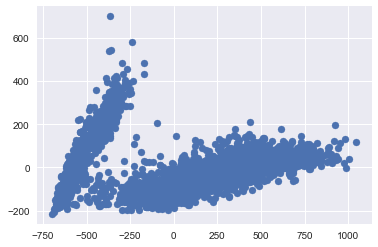

In [12]:
plt.scatter(X2[:,0], X2[:,1])

## Using the Gaussian Mixture from sklearn, we can create a model that implements the expectation-maximazation algorithm to fit the data (X). This algorithm can draw confidence ellipsoids for multivariate models (we are going to choose 2 and the default covariance-type="full").

In [13]:
gmm = GaussianMixture(2)
gmm.fit(X)
labels = gmm.predict(X)
labels

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

## Now that we have the labels of our unsupervised model, we can see if the Gaussian Mixture model was able to classify the clusters

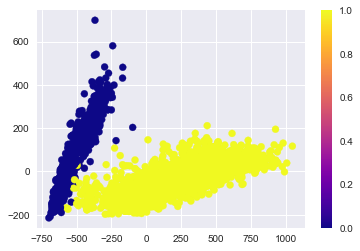

In [35]:
plt.scatter(X2[:,0], X2[:,1], c=labels, cmap='plasma')
plt.colorbar()

### This is exactly what we expected!! Now we can explore the two clusters further

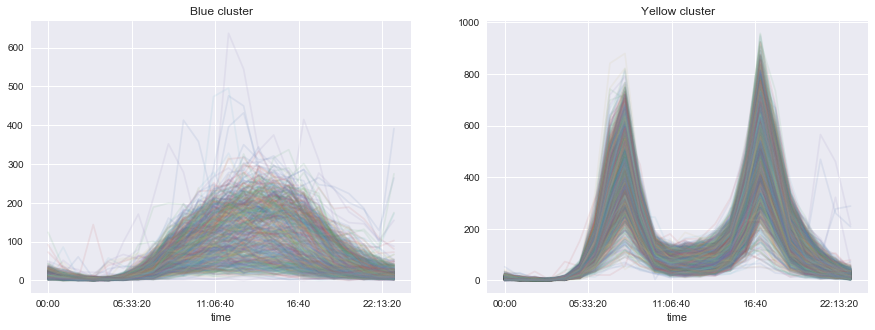

In [15]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
plt.rcParams.update({'font.size': 55})

pivoted.T[labels == 0].T.plot(legend=False, alpha=0.1, ax=ax[0])
pivoted.T[labels == 1].T.plot(legend=False, alpha=0.1, ax=ax[1])

ax[0].set_title('Blue cluster')
ax[1].set_title('Yellow cluster')

plt.show()

In [16]:
dayofweek= pd.DatetimeIndex(pivoted.columns).dayofweek

## Our hypothesis was correct, the bottom right cluster is predominantly mon-fri (0-4). Whereas, the left cluster is mostly made up of sat and sun (5&6)

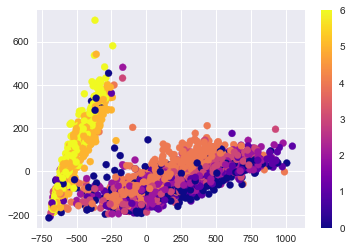

In [17]:
plt.scatter(X2[:,0], X2[:,1], c=dayofweek, cmap='plasma')
plt.colorbar()


## When we filter the "weekend" cluster to show just the weekdays, we are able to discover American holidays that falls during the weekday!! (except for 2017-02-06)

In [33]:
dates= pd.DatetimeIndex(pivoted.columns)
dates[(labels ==0) & (dayofweek<5)]

DatetimeIndex(['2012-11-22', '2012-11-23', '2012-12-24', '2012-12-25',
               '2013-01-01', '2013-05-27', '2013-07-04', '2013-07-05',
               '2013-09-02', '2013-11-28', '2013-11-29', '2013-12-20',
               '2013-12-24', '2013-12-25', '2014-01-01', '2014-04-23',
               '2014-05-26', '2014-07-04', '2014-09-01', '2014-11-27',
               '2014-11-28', '2014-12-24', '2014-12-25', '2014-12-26',
               '2015-01-01', '2015-05-25', '2015-07-03', '2015-09-07',
               '2015-11-26', '2015-11-27', '2015-12-24', '2015-12-25',
               '2016-01-01', '2016-05-30', '2016-07-04', '2016-09-05',
               '2016-11-24', '2016-11-25', '2016-12-26', '2017-01-02',
               '2017-02-06', '2017-05-29', '2017-07-04', '2017-09-04',
               '2017-11-23', '2017-11-24', '2017-12-25', '2017-12-26',
               '2018-01-01', '2018-05-28', '2018-07-04', '2018-09-03',
               '2018-11-22', '2018-11-23', '2018-12-24', '2018-12-25',
      

## Holidays and heavy snowfall (2017-02-06) [snowday](https://www.seattletimes.com/seattle-news/weather/weather-service-predicts-3-to-6-inches-of-snow-in-seattle-area/)
### Thanks for reading until the end!
-Tak Koyanagi